# Complex Graph - Multiple Models and Multiple Endpoints


### 1. Setup Project

In [1]:
import mlrun
import os

# Create the project:
project_name='realtime-pipelines'
project_dir = os.path.abspath('./')
project = mlrun.new_project(project_name, project_dir)

# Set the environment:
mlrun.set_environment(project=project.metadata.name)

> 2022-06-10 23:41:10,527 [info] loaded project realtime-pipelines from MLRun DB


('realtime-pipelines', 'v3io:///projects/{{run.project}}/artifacts')

### 2. Serving Code

In [2]:
%%writefile dummy_model.py

from typing import Any, Dict, List, Union
import mlrun
from mlrun.serving.v2_serving import V2ModelServer
from datetime import datetime
import psutil
import numpy as np
import json

class DummyModelServer(mlrun.serving.V2ModelServer):
    def load(self):
        """load and initialize the model and/or other elements"""

    def predict(self, body: dict) -> List:
        """Generate model predictions from sample."""
        print("+++++++++++++++++++ in Dummy Model Prediction ++++++++++++++++++++++")
        feats = np.asarray(body['inputs'])
        print(f'feats shape === >>> {feats.shape}')
        print("+++++++++++++++++++ out Dummy Model Prediction ++++++++++++++++++++++")
        print()
        return feats.shape

def postprocess(event):
    print("+++++++++++++++++++ in Dummy Postprocess ++++++++++++++++++++++")
    print(f'Event keys === >>> {event.keys()}')
    print("+++++++++++++++++++ out Dummy Postprocess ++++++++++++++++++++++")
    print()
    return event

def preprocess(event):
    print("+++++++++++++++++++ in Dummy Preprocess ++++++++++++++++++++++")
    print(f'Event keys === >>> {event.keys()}')
    print("+++++++++++++++++++ out Dummy Preprocess ++++++++++++++++++++++")
    print()
    return event

Overwriting dummy_model.py


### 3. Serving Graph

#### 3.1 Serving function

In [3]:
serving_function = mlrun.code_to_function(
    "model_routing", 
    filename="./dummy_model.py",
    kind="serving", 
    image="mlrun/mlrun"
)

#### 3.2 Set up multiple routes

In [4]:
models_path = 'https://s3.wasabisys.com/iguazio/models/iris/model.pkl'
path1 = models_path
path2 = models_path
path3 = models_path

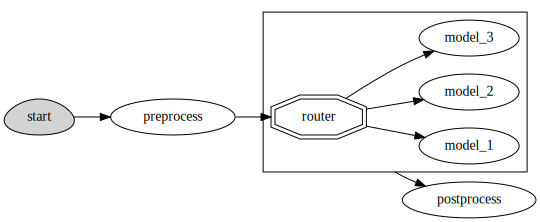

In [5]:
graph = serving_function.set_topology("flow", engine="async")

graph.add_step(handler="preprocess", name="preprocess")

router = graph.add_step("*", name="router", after="preprocess")
router.add_route(
    "model_1", 
    class_name="DummyModelServer", 
    model_path=path1,
    function='inference'
)
router.add_route(
    "model_2", 
    class_name="DummyModelServer", 
    model_path=path2,
    function='inference'
)
router.add_route(
    "model_3", 
    class_name="DummyModelServer", 
    model_path=path3,
    function='inference'
)
graph.add_step(handler="postprocess", name="postprocess", after="router").respond()

graph.plot(rankdir='LR')

### 4. Running Graph Local 

In [7]:
from dummy_model import *

#### Test endpoint #1

In [8]:
server = serving_function.to_mock_server(current_function="*")
response = server.test(path='/v2/models/model_1/predict', body={"inputs": [[1]]})
server.wait_for_completion()
response

> 2022-06-10 23:41:42,028 [info] model model_1 was loaded
> 2022-06-10 23:41:42,028 [info] model model_2 was loaded
> 2022-06-10 23:41:42,029 [info] model model_3 was loaded
> 2022-06-10 23:41:42,029 [info] Loaded ['model_1', 'model_2', 'model_3']
+++++++++++++++++++ in Dummy Preprocess ++++++++++++++++++++++
Event keys === >>> dict_keys(['inputs'])
+++++++++++++++++++ out Dummy Preprocess ++++++++++++++++++++++

+++++++++++++++++++ in Dummy Model Prediction ++++++++++++++++++++++
feats shape === >>> (1, 1)
+++++++++++++++++++ out Dummy Model Prediction ++++++++++++++++++++++

+++++++++++++++++++ in Dummy Postprocess ++++++++++++++++++++++
Event keys === >>> dict_keys(['id', 'model_name', 'outputs'])
+++++++++++++++++++ out Dummy Postprocess ++++++++++++++++++++++



{'id': 'ee47fa2f7a734c528f5aab61a1d5bf95',
 'model_name': 'model_1',
 'outputs': (1, 1)}

#### Test endpoint #2

In [9]:
server = serving_function.to_mock_server(current_function="*")
response = server.test(path='/v2/models/model_2/predict', body={"inputs": [[1, 1],[1, 1]]})
server.wait_for_completion()
response

> 2022-06-10 23:41:44,128 [info] model model_1 was loaded
> 2022-06-10 23:41:44,128 [info] model model_2 was loaded
> 2022-06-10 23:41:44,129 [info] model model_3 was loaded
> 2022-06-10 23:41:44,129 [info] Loaded ['model_1', 'model_2', 'model_3']
+++++++++++++++++++ in Dummy Preprocess ++++++++++++++++++++++
Event keys === >>> dict_keys(['inputs'])
+++++++++++++++++++ out Dummy Preprocess ++++++++++++++++++++++

+++++++++++++++++++ in Dummy Model Prediction ++++++++++++++++++++++
feats shape === >>> (2, 2)
+++++++++++++++++++ out Dummy Model Prediction ++++++++++++++++++++++

+++++++++++++++++++ in Dummy Postprocess ++++++++++++++++++++++
Event keys === >>> dict_keys(['id', 'model_name', 'outputs'])
+++++++++++++++++++ out Dummy Postprocess ++++++++++++++++++++++



{'id': 'f031e59239a54c0d94b5a268a7e93c28',
 'model_name': 'model_2',
 'outputs': (2, 2)}

#### Test endpoint #3

In [10]:
server = serving_function.to_mock_server(current_function="*")
response = server.test(path='/v2/models/model_3/predict', body={"inputs": [[3, 3, 3], [3, 3, 3], [3, 3, 3]]})
server.wait_for_completion()
response

> 2022-06-10 23:41:46,699 [info] model model_1 was loaded
> 2022-06-10 23:41:46,700 [info] model model_2 was loaded
> 2022-06-10 23:41:46,700 [info] model model_3 was loaded
> 2022-06-10 23:41:46,701 [info] Loaded ['model_1', 'model_2', 'model_3']
+++++++++++++++++++ in Dummy Preprocess ++++++++++++++++++++++
Event keys === >>> dict_keys(['inputs'])
+++++++++++++++++++ out Dummy Preprocess ++++++++++++++++++++++

+++++++++++++++++++ in Dummy Model Prediction ++++++++++++++++++++++
feats shape === >>> (3, 3)
+++++++++++++++++++ out Dummy Model Prediction ++++++++++++++++++++++

+++++++++++++++++++ in Dummy Postprocess ++++++++++++++++++++++
Event keys === >>> dict_keys(['id', 'model_name', 'outputs'])
+++++++++++++++++++ out Dummy Postprocess ++++++++++++++++++++++



{'id': '6d1526b64faa45758203694ce2b85e5a',
 'model_name': 'model_3',
 'outputs': (3, 3)}

### 5. Deploy to cluster

In [11]:
serving_function.apply(mlrun.platforms.auto_mount())
serving_function.spec.min_replicas=1
serving_function.spec.max_replicas=1
# serving_function.spec.base_spec['spec']['loggerSinks'] = [{'level': 'info'}]

In [12]:
addr = serving_function.deploy()
addr

> 2022-06-10 23:41:51,736 [info] Starting remote function deploy
2022-06-10 23:41:52  (info) Deploying function
2022-06-10 23:41:52  (info) Building
2022-06-10 23:41:52  (info) Staging files and preparing base images
2022-06-10 23:41:52  (info) Building processor image
2022-06-10 23:42:28  (info) Build complete
2022-06-10 23:42:44  (info) Function deploy complete
> 2022-06-10 23:42:44,285 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-realtime-pipelines-model-routing.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['realtime-pipelines-model-routing-realtime-pipelines.default-tenant.app.uss-sales-341.iguazio-cd1.com/']}


'http://realtime-pipelines-model-routing-realtime-pipelines.default-tenant.app.uss-sales-341.iguazio-cd1.com/'

#### Test endpoint #1 in cluster

In [13]:
serving_function.invoke(path='/v2/models/model_1/predict', body={"inputs": [[1]]})

> 2022-06-11 00:27:51,848 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-realtime-pipelines-model-routing.default-tenant.svc.cluster.local:8080/v2/models/model_1/predict'}


{'inputs': [[1]]}

#### Test endpoint #2 in cluster

In [14]:
serving_function.invoke(path='/v2/models/model_2/predict', body={"inputs": [[2]]})

> 2022-06-11 00:27:53,218 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-realtime-pipelines-model-routing.default-tenant.svc.cluster.local:8080/v2/models/model_2/predict'}


{'inputs': [[2]]}

#### Test endpoint #3 in cluster

In [15]:
serving_function.invoke(path='/v2/models/model_3/predict', body={"inputs": [[3]]})

> 2022-06-11 00:27:54,225 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-realtime-pipelines-model-routing.default-tenant.svc.cluster.local:8080/v2/models/model_3/predict'}


{'inputs': [[3]]}